## Imports

In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [99]:
from pathlib import Path
from random import sample, randint
from PIL import Image
import torch
import torch.optim as optim
from sklearn.manifold import TSNE

from omniglot import OmniglotDataset
from data import FewShotData
from model import PrototypicalNetwork
from learner import FewShotLearner
import plot

In [76]:

from PIL import Image
import os
 
Input_dir = 'dataset/Faces/train/Ishan/'
Out_dir = 'dataset/Faces/Grey/Ishan/'
a = os.listdir(Input_dir)

for i in a:
    print(i)
    I = Image.open(Input_dir+i)
    L = I.convert('L')
    L.save(Out_dir+i)

File3158.png
File3138.png
Ishan_10.png
Ishan_35.png
Ishan_15.png
File3156.png
File3137.png
File3133.png
File3144.png
File3105.png
Ishan_65.png
File3149.png
Ishan_60.png
File3112.png
Ishan_50.png
Ishan_55.png
File3115.png
File3123.png
Ishan_5.png
File3125.png
File3134.png
Ishan_70.png
File3148.png
Ishan_45.png
File3117.png
File3136.png
File3147.png
File3126.png
File3124.png
File3132.png
Ishan_95.png
File3143.png
File3111.png
File3154.png
File3110.png
File3121.png
Ishan_100.png
Ishan_40.png
File3139.png
File3155.png
Ishan_90.png
File3103.png
File3104.png
File3128.png
File3150.png
File3146.png
File3127.png
File3135.png
File3122.png
File3116.png
File3157.png
File3113.png
File3106.png
File3114.png
File3145.png


## 1. Data

In [10]:
PATH = Path('dataset/Faces/')
trn_path = PATH/'train'
test_path = PATH/'test'
val_path = PATH/'val'

# if (PATH/'images_background').exists(): 
#     (PATH/'images_background').rename(trn_path)
    
# if (PATH/'images_evaluation').exists():  
#     (PATH/'images_evaluation').rename(test_path)

### Exploratory analysis

Datasets size:

In [32]:
trn_alphabets = list(trn_path.iterdir())
test_alphabets = list(test_path.iterdir())
print(f"Persons (training/test): {len(trn_alphabets)}/{len(test_alphabets)}")

trn_classes = list(trn_path.glob('*/*'))
test_classes = list(test_path.glob('*/*'))
print(f"Persons (training/test): {len(trn_classes)}/{len(test_classes)}")

trn_images = list(trn_path.glob('*/*'))
test_images = list(test_path.glob('*/*'))
print(f"Images (training/test): {len(trn_images)}/{len(test_images)}")

Persons (training/test): 8/8
Persons (training/test): 484/88
Images (training/test): 484/88


Visualize some random images:

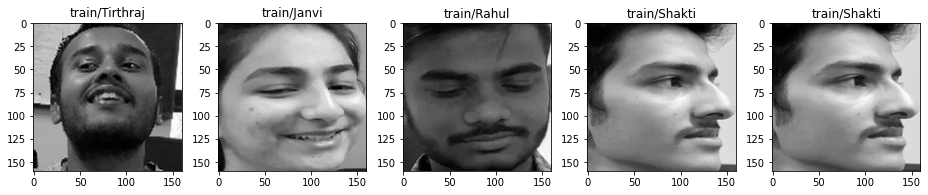

In [84]:
samples = sample(trn_images, 5)
plot.plot_images(samples, [x.parents[1].name + '/' + x.parent.name for x in samples])

Visualize some of the different instances of the same class:

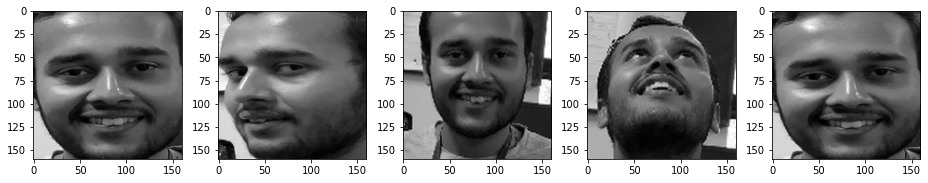

In [85]:
sample_cls = samples[0].parent
samples = sample(list(sample_cls.iterdir()), 5)
plot.plot_images(samples)

Images size:

In [86]:
print('Images size:', Image.open(samples[0]).size)

Images size: (160, 160)


### Data pre-processing

#### Validation set

Create a validation set by using 50% of the test set.

In [13]:
val_split = 0.5 # of the test set

if not val_path.exists():
    val_path.mkdir()
    test_len = len(list(test_path.iterdir()))
    k = int(test_len * val_split)
    for s in sample(test_alphabets, k=k):
        s.rename(val_path/s.name)

#### Augmentation, resize and vectorization

The dataset object makes it easy to handle the data, including load and transformation.
In this case, our dataset class performs the following processes:
1. As specified in the paper, images from each class is rotated 0, 90, 180 and 270 degrees to create 4 different classes. In this way, the number of samples and the number of classes are incremented 4 times.
2. Following the paper as well, images are resized to 28x28.
3. Finally, images are transformed to tensors, getting ready to be fitted in a neural net.

In [46]:
trn_ds = OmniglotDataset(trn_path)
val_ds = OmniglotDataset(val_path)
test_ds = OmniglotDataset(test_path)

The dataset now it is 4 time bigger:

In [47]:
trn_cls = torch.unique(trn_ds.labels)
val_cls = torch.unique(val_ds.labels)
test_cls = torch.unique(test_ds.labels)
print(f"Classes (train/val/test): {len(trn_cls)}/{len(val_cls)}/{len(test_cls)}")
print(f"Images (train/val/test): {len(trn_ds)}/{len(val_ds)}/{len(test_ds)}")

Classes (train/val/test): 32/32/32
Images (train/val/test): 1936/160/352


Visualize how one class, has now become 4 different classes. 

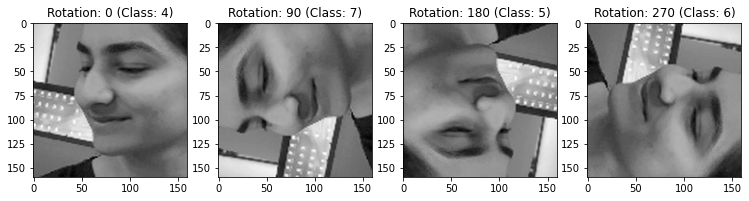

In [48]:
idx = randint(0, len(trn_ds) // 4 - 1) * 4
samples = trn_ds[idx:idx+4]
X, y = samples
plot.plot_tensor(samples[0], [f'Rotation: {i % 4 * 90} (Class: {y})' for i, y in enumerate(y)])

The tensors look as follows: 

In [49]:
X, y = trn_ds[:]
print('Features tensor (imagess):', X.size())
print('Labels tensor', y.size())

Features tensor (imagess): torch.Size([1936, 1, 160, 160])
Labels tensor torch.Size([1936])


#### Sampling

Few-shot learning, including one-shot, makes use of **episodes** for both training and evaluation. An episode is a batch of data that includes Ns support and Nq query samples for each of Nc random classes. The parameters Ns and Nc are particularly important, since they represent the number of "shots" used for learning and the number of "ways" or different classes, respectively.

The FewShotData class packs Datasets and DataLoaders for training, validation and test. Each DataLoader provides an iterator that yields episodes for Few-shot Learning.

In [80]:
data = FewShotData(trn_ds, val_ds, test_ds,
                 trn_classes_n=5,  # 5-ways (training)
                 trn_support_n=1,   # 1-shot (training)
                 trn_query_n=4,
                 eval_classes_n=5, # 5-ways (eval)
                 eval_support_n=1,  # 1-show (eval)
                 eval_query_n=4,
                 episodes_n=6)



In [81]:
len(data.val_dl), len(data.trn_dl), len(data.test_dl)

(6, 6, 6)

Visualizing some samples from a training episode:

=== Class: 0 ===

Support samples


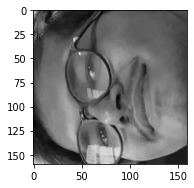

Query samples


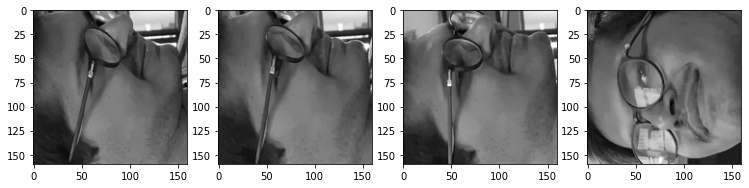

=== Class: 1 ===

Support samples


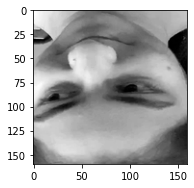

Query samples


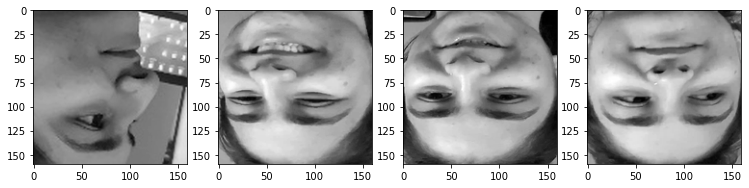

=== Class: 2 ===

Support samples


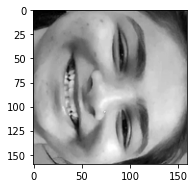

Query samples


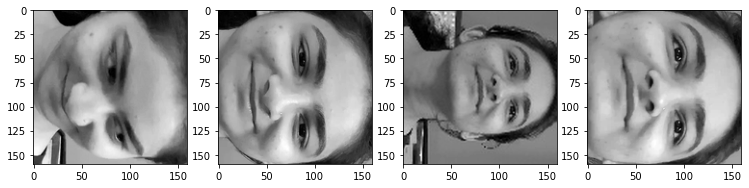

In [82]:
trn_episode = next(iter(data.trn_dl))
plot.plot_episode(*trn_episode, 3)

## 2. Model

After analyzing different models to tackle the one-shot challenge, I chose Prototypical Networks, since it is a very intuitive, but powerful model that has recently achieved state-of-the-art results.

So, let's create a Prototypical Network model.

In [52]:
model = PrototypicalNetwork()

Create a FewShotLearner, which provides handy methods for Few-shot models.

In [83]:
learner = FewShotLearner(model, data)

Train the model on 100 epoch (of 100 episodes each).

In [84]:
learner.fit(100)

Epoch trn_loss  trn_acc val_loss  val_acc
   1: 3.965130 0.791667 0.044819 0.975000 (Best)
   2: 3.798061 0.783333 0.226363 0.966667 
   3: 1.830102 0.783333 0.175598 0.975000 (Best)
   4: 1.177561 0.825000 0.042302 0.991667 (Best)
   5: 1.820939 0.716667 0.163303 0.966667 
   6: 1.716529 0.800000 0.081887 0.958333 
   7: 1.575522 0.783333 0.021884 0.991667 
   8: 1.868554 0.691667 0.034922 0.983333 
   9: 1.571633 0.750000 0.138613 0.958333 
  10: 0.276634 0.900000 0.119392 0.983333 
  11: 1.242470 0.741667 0.097925 0.975000 
  12: 0.814411 0.808333 0.174874 0.975000 
  13: 0.671473 0.791667 0.231328 0.941667 
  14: 0.743991 0.733333 0.121481 0.966667 
  15: 0.712578 0.758333 0.109824 0.975000 
  16: 0.604402 0.833333 0.142458 0.966667 
  17: 0.581610 0.825000 0.092504 0.966667 
  18: 0.494299 0.866667 0.016897 0.991667 
  19: 0.405060 0.850000 0.025338 0.983333 
  20: 0.458102 0.791667 0.058142 0.991667 
  21: 0.414398 0.825000 0.016241 0.991667 
  22: 0.558173 0.841667 0.082599 0.96

In [38]:
learner.fit(100)

Epoch trn_loss  trn_acc val_loss  val_acc
   1: 1.471124 0.606600 0.570891 0.829467 (Best)
   2: 0.680706 0.798867 0.438640 0.871967 (Best)
   3: 0.525663 0.839600 0.428156 0.883600 (Best)
   4: 0.433224 0.868467 0.348829 0.898967 (Best)
   5: 0.371747 0.886467 0.301458 0.912967 (Best)
   6: 0.341663 0.896100 0.295607 0.918133 (Best)
   7: 0.329138 0.900033 0.271397 0.923800 (Best)
   8: 0.289695 0.910200 0.280228 0.922433 
   9: 0.273544 0.915933 0.294219 0.922067 
  10: 0.265860 0.916633 0.251985 0.928467 (Best)
  11: 0.237748 0.925567 0.271432 0.923667 
  12: 0.233114 0.927567 0.287699 0.925133 
  13: 0.256017 0.920600 0.247906 0.927067 
  14: 0.231440 0.928133 0.242590 0.937200 (Best)
  15: 0.206163 0.934400 0.290826 0.924800 
  16: 0.218224 0.929533 0.258414 0.932767 
  17: 0.205067 0.936567 0.244000 0.933267 
  18: 0.210032 0.933867 0.292914 0.930633 
  19: 0.198862 0.938667 0.227026 0.936500 
  20: 0.197920 0.937500 0.212618 0.941300 (Best)
  21: 0.197268 0.937767 0.225835 0.941

## 3. Results

### Metrics

Compute average accuracy for 10 epochs from the test set.

In [39]:
_, acc = learner.evaluate(10, test=True)
print(f'Accuracy on test set: {acc:.6f}')

Accuracy on test set: 0.950223


In [85]:
_, acc = learner.evaluate(10, test=True)
print(f'Accuracy on test set: {acc:.6f}')

Accuracy on test set: 0.989167


Note 1: The Prototypical Network for Few-shot Learning paper reports an accuracy of 96.0% for 20-ways 1-shot classification. However, they used 4800 classes for training, while I only used the 3856 classes provided in the training set.

Note 2: I considered that the model performs "good enought" to demostrate how to solve the few-shot learning challenge. I focused on following the Prototypical Network for Few-shot Learning as much as possible and I did not put much efforts on fine-tunning to achieve the maximum possible accuracy. Some actions that would have lead to improve accuracy include: more sophisticate embedding functions, regularization techniques, larger images, etc.

### Visualize predictions

Yield a test episode.

In [86]:
test_episode = next(iter(data.test_dl))
(s_X, s_y), (q_X, q_y) = test_episode

Make predictions using the trained model.

In [87]:
model = model.cpu()
log_probs = model(s_X, s_y, q_X)
probs = torch.exp(log_probs)

Visualize high-confidence correctly-classified samples.

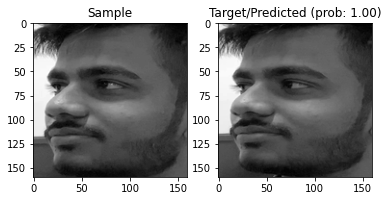

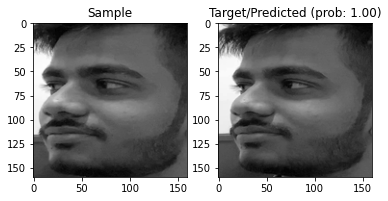

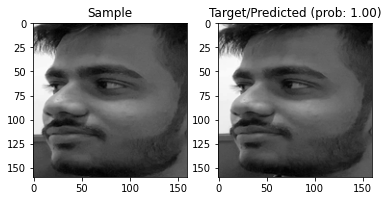

In [88]:
plot.plot_predictions(*test_episode, probs, correct=True, descending=True)

Visualize low-confidence correctly-classified samples.

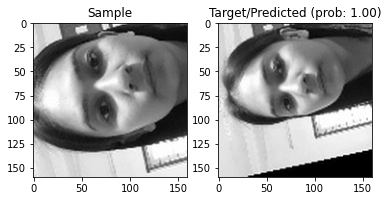

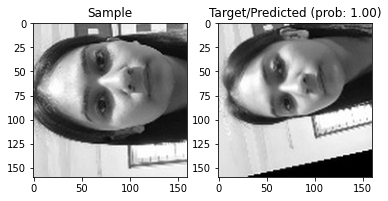

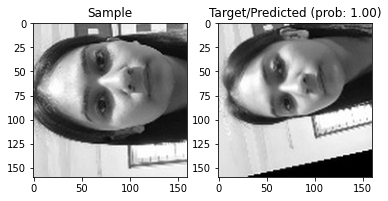

In [89]:
plot.plot_predictions(*test_episode, probs, correct=True, descending=False)

Visualize low-confidence misclassified samples.

In [90]:
plot.plot_predictions(*test_episode, probs, correct=False, descending=False)


# NONE Misclassified Predictions!!!!

Visualize high-confidence misclassified samples.

In [91]:
plot.plot_predictions(*test_episode, probs, correct=False, descending=True)

# NONE Misclassified Predictions!!!!

### t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

Use the model's embedding function to compute embeddings.

In [105]:
q_embs = model.emb_fn(q_X)
q_embs = q_embs.detach()
q_embs.size()

torch.Size([20, 6400])

Compute t-SNE of the embedding vectors.

In [106]:
tsne = TSNE()
q_tsne = tsne.fit_transform(q_embs)

In [107]:
import plot

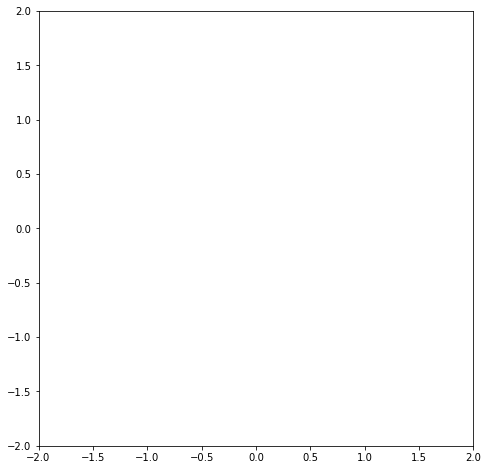

In [108]:
plot.plot_tsne(q_X, q_tsne)